# 5: Problems with Machine Learning on Graphs
Dive deeper into:
-  Predicting missing links in a graph
-  Detecting meaningful structures such as communities
-  Detecting graph similarities and graph matching

## Link Prediction
Predict if or if not there is an edge between two nodes when this status is unknown, here we have $E = E_o \cup E_u$ where $E_o$ are the observed links and edges $E_u$ are unknown links. For Link Prediction, we wish to exploit $E_o$ to estimate $E_u$. This is common in temporal graph systems where we want to estimate t+1; also is used widely in domains such as recommender systems or find hidden connections within networks. We have two families of approaches:
-  Similarity-based
-  Embedding-based

### Similarity-based Methods
Estimate a similarity function between each couple of nodes in a graph. Divide into sub-families:
-  **Index-based**: Simple calculation of index based on neighboursof a given couple of nodes. Based on calculation of a simple index from information obtained by analysing the neighbours of two disconnected nodes...
    -  Resource allocation index: Sum of 1/(Num neighbours for v nodes)



In [ ]:
import networkx as nx
edges = [[1,3], [2,3], [2,4], [4,5], [5,6], [5,7]]
G = nx.from_edgelist(edges)
preds = nx.resource_allocation_index(G, [(1,2), (2,5), (3,4)]) # second arg is a list of possible edges

In [ ]:
list(preds) # p. of each edge is 0.5

**Jaccard Coefficient**: Neighbours of nodes u and v; intersection over union

In [ ]:
preds = nx.jaccard_coefficient(G, [(1,2), (2,5), (3,4)]) 
list(preds)

There are other methods too such as *adamic_adar_index* and *preferential_attachment*.

-  **Community-based**: Index computed using information about community to which a given couple of nodes belong first


Community Common Neighbour: Computes number of common neighbours and adds this to number of common neighbours belonging to same community.

In [ ]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

# assign community property
G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1

preds = nx.cn_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds)) # output not in range (0,1)
nx.draw(G)

Community resource allocation: Merges information obtained from neighbours of nodes with community. Algorithm where we take sum of nodes and allocate 1 if belongs to same community, 0 otherwise and normalise by neighbours of node v

In [ ]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.ra_index_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
nx.draw(G) # nodes in same community have a higher value in index

Now we can look at more complex techniques based on ML; and edge embedding to perform prediction of unknown edges.

### Embedding-based Mehods
Here we approach link prediction as supervised classification. For a given graph, each couple of nodes is represented as a feature vector, and class label assigned to node couples. The whole process can be summarised into two main steps:
1.  For each node of the graph G, its embedding vector is computed using a node2vec algorithm
2.  For all the possible couple of nodes in the graph, the embedding is computed using edge2vec

So we have a generic ML algorithm to generate feature vectors to solve classification problem.

In [ ]:
import networkx as nx
import pandas as pd

edgelist = pd.read_csv("cora.cites", sep='\t', header=None, names=["target", "source"])
G = nx.from_pandas_edgelist(edgelist)
#nx.draw_graph(G)

In [ ]:
from stellargraph.data import EdgeSplitter

# stellargraph to split datasaet
# will have positive and negative instances
edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

In [ ]:
edgeSplitter = EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

In [ ]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 

# generate embedding of each couple of nodes in training set
node2vec = Node2Vec(graph_train)
model = node2vec.fit()
# hadamard to generate embedding of each couple of nodes in training set
# values used as feature vectors for training of model
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

In [ ]:
# embeddings may change between runs?
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# train with RF classifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_embeddings, labels_train);

In [ ]:
from sklearn import metrics

y_pred = rf.predict(test_embeddings)

print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))

## Detecting Meaningful Structures such as Communities
How to identify clusters and communities within graphs; can be used eg. in text mining to identify emerging topics or cluster documents that refer to single events/topics. We want so that nodes belonging to the same community are tightly connected to each other and weakly connected with nodes from other communities; belong to categories:
-  Non-overlapping: Community detection algorithms that provide one-to-one association between nodes and communities, so no overlapping nodes between communities
-  Overlapping: Allow node to be in more than one community; so we have overlapping communities

### Embedding-based community detection
Shallow clustering techniques such as node embeddings; project to vector space where we can measure distance to gauge similarity. Standard K-means, Gaussian Mixture, DBSCAN..

In [1]:
import networkx as nx
G = nx.barbell_graph(m1=10, m2=4)

In [4]:
from gem.embedding.hope import HOPE
gf = HOPE(d=4, beta=0.01) # get dense representation
gf.learn_embedding(G)
embeddings = gf.get_embedding()

SVD error (low rank): 0.052092


In [5]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0)
labels = gm.fit_predict(embeddings)

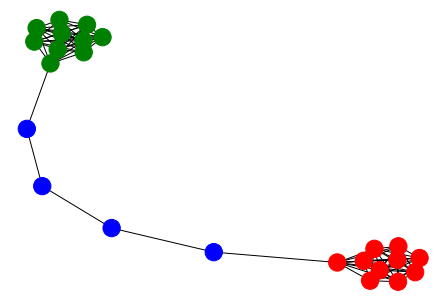

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

colors = ["blue", "green", "red"]
nx.draw_spring(G, node_color=[colors[label] for label in labels]);
# we see correct grouping into three different communities; reflecting internal graph structure

### Spectral Methods and Matrix Factorisation
We can also process the adjacency matrix or laplacian matrix that represents the connectivity properties of graph. Can consider eigenvectors of Laplacian matrix etc.. We can consider spectral clustering as a special case of embedding-based community deection algorithm, where embedding method is called spectral embedding, obtained by considering first k-eigenvectors of laplacian matrix.
-  Laplacian Matrix: Graph in Matrix representation
-  Eigenvector: Ax = lambda.x; where lambda is the eigenvalue of matrix A and X is the eigenvector of A associated with lambda.

In [12]:
from communities.algorithms import spectral_clustering
import numpy as np

adj = np.array(nx.adjacency_matrix(G).todense())
communities = spectral_clustering(adj, k=2)

The adjacency matrix/Laplacian can be decomposed with matrix factorisation techniques such as singular value decomposition (SVD) or non-negative matrix factorisation (NMF). E.g.

In [15]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2)
score = nmf.fit_transform(adj)
print(score)
communities = [set(np.where(score[:,ith]>0)[0]) for ith in range(2)] # threshold to belong to community set at 0
print(communities) # these are overlapping community detection algs; communities may belong to more than one community

[[8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.24699222e-01 0.00000000e+00]
 [8.34061214e-01 8.50135597e-06]
 [9.37256747e-02 1.67595391e-04]
 [1.05323940e-02 1.51534609e-03]
 [1.18354664e-03 1.34998499e-02]
 [1.31541999e-04 1.20141650e-01]
 [7.25398817e-06 1.06914689e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]
 [0.00000000e+00 1.05714633e+00]]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}, {9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}]


### Probabilty Models
**Stochastic Block Model** assumes that nodes can be partitioned into *K* disjoint communities and each community has a defined probability of being connected to another. For a network of *n* nodes and *K* communities, the generative model is parameterised with:
- **Membership Matrix**: M, which is a n*K matrix and represents the probability a given node belongs to class k
- **Probability Matrix:** B, which is K*K and represents the edge probability between a node belonging to community i and a node belonging to community j

In the SBM we can invert the formulation and reduce community detection problem to posterior estimation of membership matrix M from matrix A via maximum likelihood estimation. This mode, and the Erdos-Renyi model has the advantage of describing a relationship between communities, thus identifying community-community relationships. 

### Cost Function Minimization
Optimise a given cost function that represents a graph structure and penalises edges across communities vs edges within communities. So build a measure of quality for a community then optimise node association to communities to maximise quality of partitioning. We have a cost that is associated with having a link between two nodes of different communities.

$\sum\limits_{i,j \in E} A$<sub>$i,j$</sub>$(1-s_is_j)$

So:
-  If two connected nodes $A$<sub>$i,j$</sub> belong to different communities, $s_is_j$=-1; the contribution provided by the edge is 0
-  If not connected, $A$<sub>$i,j$</sub> = 0
-  If belong to same community,  $A$<sub>$i,j$</sub>=1 as $s_is_j$=0

Therefore we want to find the best community assignment to minimise the preceeding function; however this only applies to binary community detection thus is limited in approach.

Another popular algorithm is the Louvain method (named after the university) aiming to maximise modularity and iteratively computes the following steps
1.  **Modularity optimisation**: Nodes are swept iteratively, for each node we compute change of modularity $Q$ there would be if the node were to be assigned to each community of its neighbours. Once all $\triangle Q$ are computed, the node is assigned to the community that provides the largest increase. If no increase than the community it is in, then the node remains. This optimisation process continues until no changes are induced.
2.  **Node aggregation**: Build new network by grouping all nodes in the same community and connect communities using edges that result from sum of all edges across the two communities. Edges within communities are accounted for by self-loops that have weights from the sum of all edge weights belonging to the community.

In [ ]:
# communities library has an implementation
from commnities.algorithms import louvain_method
communities = louvain_method(adj)

# can also use Girvan-Newman algorithm; based on iteratively removing edges that have highest betweenness centrality
# to create connected component communities; this can be quite expensive and scales n.m^2; where m is num edges
# and 2 is num nodes so shouldn't be used when dealing with large datasets
from communities.algorithms import girvan_newman
communities = girvan_newman(adj, n=2) 

### Detecting Graph Similarities and Graph Matching
Can use to say if an object should/should not be a member of a group. There are several metrics, such as Euclidean, Manhattan distance and cosine similarity etc.. But these can struggle on non-Euclidean structuressuch as graphs. Algorithmic approaches can be computationally prohibitive, so ML comes into play here. Sowe have three main categories:
-  Graph embedding-based methods: Embedding techniques to obtain embedded representation of graph and exploit representation to learn similarity function
    -  E.g. DeepWalk and Node2Vec
-  Graph kernel-based methods: Define similarity between graphs by measuring similarity of constituting substructures
    -  E.g. Deep Graph Kernel
-  Graph Neural Network: Jointly learn embedded representation and similarity function
    -  Can better leverage graph features for specific learning task; trained to estimate proximity distance between two graphs.